In [2]:
import parent
import data
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.decomposition import PCA

In [67]:
triangles = data.get_dataset_triangles("train", data_size=64, samples=2)
triangles = torch.cat([tensors[0] for tensors in triangles[0]])

In [208]:
def sample_from_image(image, index, position):

    image_shape = image.shape[2:]

    assert(position.shape[0] == index.shape[0])
    assert(position.shape[1] == len(image.shape) - 2)
    
    # only implemented for dimension 2
    assert(position.shape[1] == 2)
    
    # http://supercomputingblog.com/graphics/coding-bilinear-interpolation/2/
    
    #Wrong, fix corner positions
    xPrime = .5 + position[:, 0] * (image_shape[0] - 1)
    yPrime = .5 + position[:, 1] * (image_shape[1] - 1)
    
    q12x = torch.floor(xPrime)
    q12y = torch.floor(yPrime)
    
    q12x = torch.clamp(q12x, 0, image_shape[0] - 1)
    q12y = torch.clamp(q12y, 0, image_shape[1] - 1)
    
    q22x = torch.ceil(xPrime)
    q22y = q12y
    
    q22x = torch.clamp(q22x, 0, image_shape[0] - 1)
    
    q11x = q12x
    q11y = torch.ceil(yPrime)
    
    q11y = torch.clamp(q11y, 0, image_shape[1] - 1)
    
    q21x = q22x
    
    q21y = q11y

    q11 = image[index, 0, q11x.long(), q11y.long()]
    q12 = image[index, 0, q12x.long(), q12y.long()]
    q21 = image[index, 0, q21x.long(), q21y.long()]
    q22 = image[index, 0, q22x.long(), q22y.long()]
    
    factor = (q21x - xPrime)
    
    

    R1 = factor * q11 + (1 - factor) * q21
    R2 = factor * q12 + (1 - factor) * q22
    
    factor = (yPrime - q12y)
    
    res = factor * R1 + (1 - factor) * R2
    

    
    return res

class ResidualBlock(torch.nn.Module):
    def __init__(self, features):
        super(ResidualBlock, self).__init__()
        self.layer1 = nn.Linear(features, features)
        self.layer2 = nn.Linear(features, features)
        self.layer3 = nn.Linear(features, features)
        #torch.nn.init.zeros_(self.layer3.weight)
        #torch.nn.init.zeros_(self.layer3.bias)
    def forward(self, x):
        y = F.relu(self.layer1(x))
        y = F.relu(self.layer2(y))
        y = self.layer3(y)
        return x + y

    
    

class RegistrationNetwork(torch.nn.Module):
    def __init__(self, dimension):
        super(RegistrationNetwork, self).__init__()

        self.position_embedding_dim = 1 * dimension
        
        multiplier=1
        
        self.layer1 = nn.Linear(self.position_embedding_dim, multiplier * 128)
        self.blocks = nn.Sequential(*[ResidualBlock(multiplier * 128) for _ in range(4)])
        self.layer3 = nn.Linear(multiplier * 128, dimension)
        
        torch.nn.init.zeros_(self.layer3.weight)
        torch.nn.init.zeros_(self.layer3.bias)
    
    def embed_position(self, position):
        return position
        out = []
        for l in range(1, 9):
            out.append(torch.sin(position * np.pi * l))
            out.append(torch.cos(position * np.pi * l))
        ret = torch.cat(out, 1)
        return ret / 20
    
    def forward(self, position):
        position_embedding = self.embed_position(torch.clip(position, 0, 1))
        
        x = torch.cat([position_embedding], axis=1)
        x = F.relu(self.layer1(x))
        x = self.blocks(x)
        x = self.layer3(x)
        
        x = position + x
        
        return x
class TrainingProcedure(torch.nn.Module):
    def __init__(self, image_tensor, batch_size, dimension):
        super(TrainingProcedure, self).__init__()
        self.image_tensor = image_tensor.cuda()
        self.num_images = image_tensor.shape[0]
        self.registration_network01 = RegistrationNetwork(dimension)
        self.registration_network10 = RegistrationNetwork(dimension)

        self.batch_size = batch_size
        self.dimension = dimension
    
    def network_select(self, image_A_index, image_B_index, position):
        return image_A_index * self.registration_network01(position) + image_B_index * self.registration_network10(position)
    
    def forward(self):
        device = next(self.registration_network01.parameters()).device
        image_A_index = torch.randint(0, self.num_images, size=[self.batch_size, 1], device=device)
        image_B_index = 1 - image_A_index
        image_A_position = torch.rand((self.batch_size, self.dimension), device=device)
        
        image_B_position = self.network_select(image_A_index, image_B_index, image_A_position)
        
        
        image_A_intensity = sample_from_image(self.image_tensor, image_A_index, image_A_position)
        image_B_intensity = sample_from_image(self.image_tensor, image_B_index, image_B_position)
        
        fx_noise = torch.randn(tuple(image_B_position.shape), device=image_B_position.device) * .01
        
        approx_image_A_position = self.network_select(image_B_index, image_A_index, image_B_position + fx_noise)
        
        return (
            torch.mean((image_A_intensity - image_B_intensity)**2),
            torch.mean((image_A_position - approx_image_A_position)**2)
        )
        
        
        
        
        

p = TrainingProcedure(triangles, 2048, 2)
        

In [209]:
p.cuda()
optimizer = torch.optim.Adam(p.parameters(), lr=.001)
p.train()

TrainingProcedure(
  (registration_network01): RegistrationNetwork(
    (layer1): Linear(in_features=2, out_features=128, bias=True)
    (blocks): Sequential(
      (0): ResidualBlock(
        (layer1): Linear(in_features=128, out_features=128, bias=True)
        (layer2): Linear(in_features=128, out_features=128, bias=True)
        (layer3): Linear(in_features=128, out_features=128, bias=True)
      )
      (1): ResidualBlock(
        (layer1): Linear(in_features=128, out_features=128, bias=True)
        (layer2): Linear(in_features=128, out_features=128, bias=True)
        (layer3): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): ResidualBlock(
        (layer1): Linear(in_features=128, out_features=128, bias=True)
        (layer2): Linear(in_features=128, out_features=128, bias=True)
        (layer3): Linear(in_features=128, out_features=128, bias=True)
      )
      (3): ResidualBlock(
        (layer1): Linear(in_features=128, out_features=128, bias=True)
   

In [210]:
for _ in range(1000000):
    optimizer.zero_grad()
    Lsim, Linv = p()

    loss = Lsim + 2048 * Linv
    loss.backward()
    optimizer.step()

    if _ % 100 == 0:
        print(Lsim, Linv)

tensor(1.1242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1331, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.8535e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1731, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.8920e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1066, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.8238e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1045, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1223, device='cuda:0', grad_fn=<MeanBackward0>) tensor(9.6869e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1022, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0001, 

tensor(0.7645, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7863, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7906, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7517, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7060, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7660, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7083, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7674, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7202, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7734, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7612, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8105, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7597, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7676, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7849, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7658, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6975, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7173, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7888, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7528, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7775, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7546, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7075, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6999, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7593, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7238, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7707, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6780, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7639, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7342, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7512, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7339, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7084, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7252, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7333, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7350, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7419, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7534, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7445, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7482, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7541, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7178, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7547, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7442, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7410, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7099, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7504, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7156, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7398, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7588, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7456, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7758, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7538, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7497, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7057, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7573, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7400, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6844, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7655, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7148, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7195, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7595, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7078, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7080, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7394, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7652, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7051, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7373, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7069, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7351, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7385, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7107, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7441, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7634, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7327, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6917, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7704, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7063, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7096, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7511, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7366, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7582, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7316, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7363, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7824, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7923, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7850, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7256, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7279, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7296, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7516, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7564, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7487, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7147, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7247, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7258, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7035, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7326, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7280, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7352, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7371, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7269, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7895, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7532, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7121, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6819, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7267, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7334, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7390, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.6859, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7416, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7311, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7495, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7384, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7031, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7387, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7207, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7365, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7162, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7457, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7007, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7155, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7745, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7513, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7288, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7302, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7415, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7242, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7470, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7378, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7440, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7062, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7136, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7158, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7332, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7699, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7122, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7293, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7026, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7320, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7282, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7335, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6981, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7436, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7545, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7281, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7354, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7404, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7073, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7403, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7688, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7115, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7235, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6864, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7106, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7227, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7475, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7338, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7071, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6988, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6979, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7337, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7171, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7250, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7359, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7367, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7304, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6942, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7095, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7377, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7325, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7313, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.8089, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7737, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7530, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7225, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7540, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7490, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7376, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7529, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7381, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7606, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7783, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7503, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7110, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7103, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7114, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7213, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7451, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7154, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7406, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7179, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7462, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7085, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6883, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7389, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7074, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7116, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6584, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7388, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7125, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7169, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7554, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6991, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7047, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7232, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7685, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7164, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7773, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7183, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7241, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6841, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7553, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7505, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7353, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7449, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7600, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6938, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7744, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6940, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6993, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7185, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7226, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7094, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7093, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7429, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7294, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

tensor(0.7184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6851, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7617, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6944, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7303, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7133, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7527, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7414, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0002, device='cuda:0',

KeyboardInterrupt: 

In [211]:
import numpy as np

D = 64
x, y = np.mgrid[0:1:D * 1j, 0:1:D * 1j]

x = x.flatten()
y = y.flatten()

position = torch.tensor(np.concatenate([[x], [y]]).transpose())


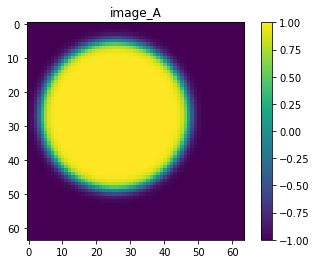

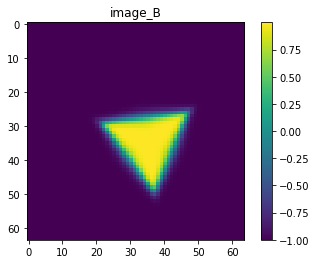

In [212]:

image_A_index = 1
image_B_index = 0
position_in_image_A = torch.tensor(np.concatenate([[x], [y]]).transpose())
image_A_values = sample_from_image(triangles, image_A_index *  torch.ones(D**2).long(), position).reshape(D, D)
plt.imshow(image_A_values)
plt.title("image_A")
plt.colorbar()
plt.show()


image_B_values = sample_from_image(triangles, image_B_index *  torch.ones(D**2).long(), position).reshape(D, D)
plt.imshow(image_B_values)
plt.title("image_B")
plt.colorbar()
plt.show()


In [213]:
#image_A_index += 1

D = 64

p_A_grid = position_in_image_A.reshape([D, D, 2]).detach().cpu()

position_in_image_B = p.network_select(
    image_A_index *  torch.ones((D**2, 1)).long().cuda(),
    image_B_index *  torch.ones((D**2, 1)).long().cuda(),
    position_in_image_A.float().cuda()
)

p_B_grid = position_in_image_B.reshape([D, D, 2]).detach().cpu()

approx_position_in_image_A = p.network_select(
    image_B_index *  torch.ones((D**2, 1)).long().cuda(),
    image_A_index *  torch.ones((D**2, 1)).long().cuda(),
    position_in_image_B
)
ap_A_grid = approx_position_in_image_A.reshape([D, D, 2]).detach().cpu()


In [214]:
position_in_image_B.shape

torch.Size([4096, 2])

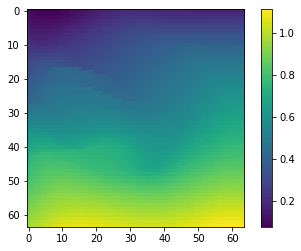

In [215]:
plt.imshow(p_B_grid[:, :, 0])
plt.colorbar()

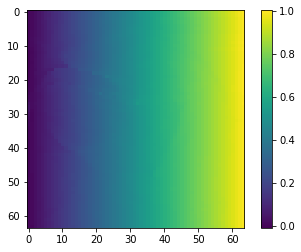

In [216]:
plt.imshow(approx_position_in_image_A.reshape([D, D, 2])[:, :, 1].detach().cpu())
plt.colorbar()

In [217]:
import visualize

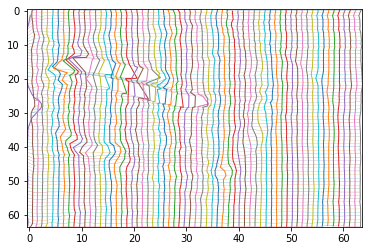

In [218]:
visualize.show_as_grid(ap_A_grid.transpose(0, 2))

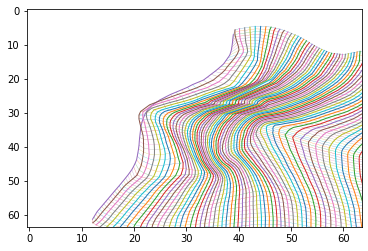

In [219]:
visualize.show_as_grid(p_B_grid.transpose(0, 2))

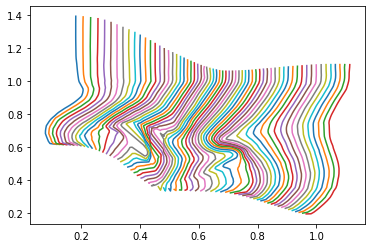

In [220]:
plt.plot(p_B_grid.transpose(0, 2)[0], p_B_grid.transpose(0, 2)[1])
plt.show()

In [167]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
